# Importing libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Creating dataset (given in question)

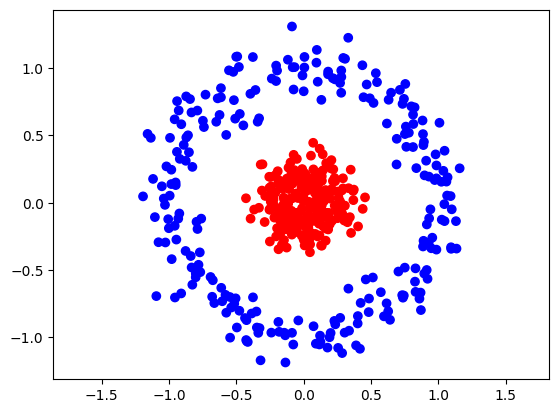

In [2]:
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
y_train = np.where(y_train == 0, -1, y_train)
y_test = np.where(y_test == 0, -1, y_test)
plt.scatter(X[:,0], X[:,1], c=y, cmap=colors.ListedColormap(["blue", "red"]))
plt.axis('equal')
plt.show()

In [3]:
pd.Series(y).value_counts()

1    250
0    250
Name: count, dtype: int64

### The dataset is balanced. 

# Implementing AdaBoost Algorithm from scratch

In [4]:
class Adaboost:
    def __init__(self,n_learners,eta=0.5):
        self.n_learners = n_learners
        self.eta = eta 
        self.learners=[]
        self.alphas = []
        self.errors=[]

    def fit(self,X,y):
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples

        for _ in range(self.n_learners):
            weak_learner = DecisionTreeClassifier(max_depth=1)
            weak_learner.fit(X,y, sample_weight=w)
            y_pred = weak_learner.predict(X)
            error = np.sum(w[y != y_pred]) / np.sum(w)

            alpha = self.eta * 0.5 * np.log((1-error) / (error + 1e-10))

            w = w* np.exp(-alpha*y_pred*y)
            w = w/np.sum(w)

            self.alphas.append(alpha)
            self.learners.append(weak_learner)
            self.errors.append(error)

    def predict(self,X):
        predictions = np.zeros(X.shape[0])

        for alpha,learner in zip(self.alphas, self.learners):
            predictions += alpha * learner.predict(X)

        predictions = np.sign(predictions)

        return predictions
    
    def plot_decision_boundaries(self, X, y):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        fig, ax = plt.subplots(1, self.n_learners, figsize=(15, 3))

        if self.n_learners == 1:
            ax = [ax]

        cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
        cmap_bold = ['#FF0000', '#0000FF']

        for i, learner in enumerate(self.learners):
            Z = learner.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            ax[i].contourf(xx, yy, Z, cmap=cmap_light)
            ax[i].scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k', s=20)
            ax[i].set_title(f'Weak Learner {i + 1}')
            ax[i].set_xlim(xx.min(), xx.max())
            ax[i].set_ylim(yy.min(), yy.max())
        
        plt.tight_layout()
        plt.show()

    
    def plot_final_decision_boundary(self, X, y):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
        cmap_bold = ['#FF0000', '#0000FF']

        plt.contourf(xx, yy, Z, cmap=cmap_light)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k', s=20)
        plt.title('Final AdaBoost Decision Boundary')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.tight_layout()
        plt.show()
        

# Hyperparameter tuning on Adaboost algorithm

In [5]:
from sklearn.metrics import accuracy_score

eta_values = np.arange(0,1,0.1)
n_learners_values=np.arange(1,10,2)

best_eta=None
best_n_learner = None
max_score = float('-inf')

for eta in eta_values:
    for n_learners in n_learners_values:
        model = Adaboost(n_learners=n_learners, eta=eta)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test,y_pred)

        if score > max_score:
            max_score = score
            best_eta=eta
            best_n_learner = n_learners

print(f"Best eta value : {best_eta}")
print(f"Best n_learners value : {best_n_learner}")
print(f"Accuracy score on best parameters: {max_score}")

Best eta value : 0.8
Best n_learners value : 9
Accuracy score on best parameters: 0.904


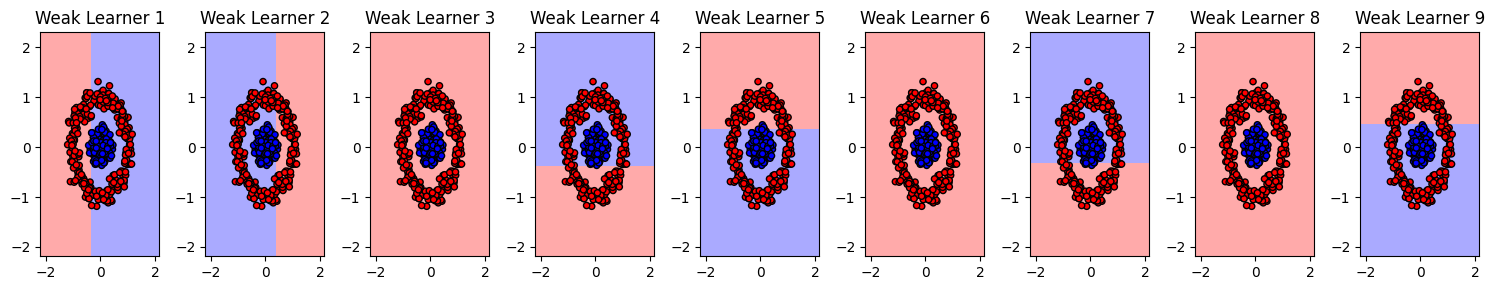

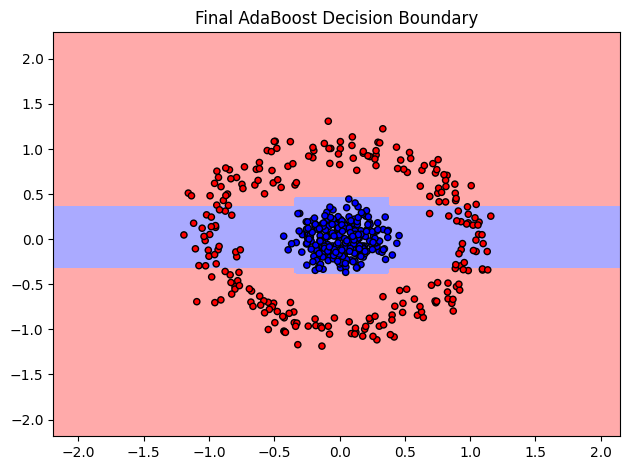

In [6]:
ada = Adaboost(best_n_learner,best_eta)
ada.fit(X_train,y_train)
ada.plot_decision_boundaries(X,y)
ada.plot_final_decision_boundary(X,y)

In [7]:
print(classification_report(y_test,ada.predict(X_test)))

              precision    recall  f1-score   support

          -1       1.00      0.80      0.89        61
           1       0.84      1.00      0.91        64

    accuracy                           0.90       125
   macro avg       0.92      0.90      0.90       125
weighted avg       0.92      0.90      0.90       125



In [8]:
print('Alpha Values')
print(*[float(i) for i in ada.alphas])
print('')
print('Error Values')
print(*[float(i) for i in ada.errors])

Alpha Values
0.32629980093047634 0.2833562915527898 0.3118787964913132 0.28978156743524985 0.2882537291623094 0.34885299837828754 0.25346810312122525 0.20375466066985864 0.294316069656029

Error Values
0.30666666666666664 0.3299545276743499 0.314385194994924 0.3264129546703025 0.3272533159331341 0.29481076770652814 0.3466787843740696 0.3753373196374411 0.32392540178860635


# Task 2: Incorporating Various weak models

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import clone

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin

class NewAdaboost(BaseEstimator, ClassifierMixin):
    def __init__(self, base_learners, n_learners=50, eta=0.5):
        self.base_learners = base_learners
        self.n_learners = n_learners
        self.eta = eta
        self.learners = []
        self.alphas = []
        self.errors=[]

    def fit(self, X, y):
        n_samples = X.shape[0]
        w = np.ones(n_samples) / n_samples
        
        for i in range(self.n_learners):
            learner = clone(self.base_learners[i % len(self.base_learners)])
            learner.fit(X, y, sample_weight=w)
            y_pred = learner.predict(X)
            
            error = np.sum(w * (y_pred != y)) / np.sum(w)
            
            alpha = self.eta * np.log((1 - error) / error)
            
            w = w * np.exp(-alpha * y * y_pred)
            w = w / np.sum(w)
            
            self.learners.append(learner)
            self.alphas.append(alpha)
            self.errors.append(error)

    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
        for alpha, learner in zip(self.alphas, self.learners):
            final_predictions += alpha * learner.predict(X)
        
        return np.sign(final_predictions)
    
    def plot_decision_boundaries(self, X, y):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        fig, ax = plt.subplots(1, self.n_learners, figsize=(15, 3))

        if self.n_learners == 1:
            ax = [ax]

        cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
        cmap_bold = ['#FF0000', '#0000FF']

        for i, learner in enumerate(self.learners):
            Z = learner.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            ax[i].contourf(xx, yy, Z, cmap=cmap_light)
            ax[i].scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k', s=20)
            ax[i].set_title(f'Weak Learner {i + 1}')
            ax[i].set_xlim(xx.min(), xx.max())
            ax[i].set_ylim(yy.min(), yy.max())
        
        plt.tight_layout()
        plt.show()

    
    def plot_final_decision_boundary(self, X, y):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
        cmap_bold = ['#FF0000', '#0000FF']

        plt.contourf(xx, yy, Z, cmap=cmap_light)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k', s=20)
        plt.title('Final AdaBoost Decision Boundary')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.tight_layout()
        plt.show()
        

In [11]:
weak_learners = [
    DecisionTreeClassifier(max_depth=1, random_state=42),
    DecisionTreeClassifier(max_depth=3, random_state=42),
    LogisticRegression(solver='liblinear', random_state=42,max_iter=10000),
    SVC(kernel='linear', random_state=42),
    #LinearDiscriminantAnalysis()
]

In [12]:
from sklearn.metrics import accuracy_score

eta_values = np.arange(0,1,0.1)
n_learners_values=np.arange(1,50,5)

best_eta=None
best_n_learner = None
max_score = float('-inf')

for eta in eta_values:
    for n_learners in n_learners_values:
        model = NewAdaboost(base_learners=weak_learners,n_learners=n_learners, eta=eta)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test,y_pred)

        if score > max_score:
            max_score = score
            best_eta=eta
            best_n_learner = n_learners

print(f"Best eta value : {best_eta}")
print(f"Best n_learners value : {best_n_learner}")
print(f"Accuracy score on best parameters: {max_score}")

Best eta value : 0.1
Best n_learners value : 11
Accuracy score on best parameters: 1.0


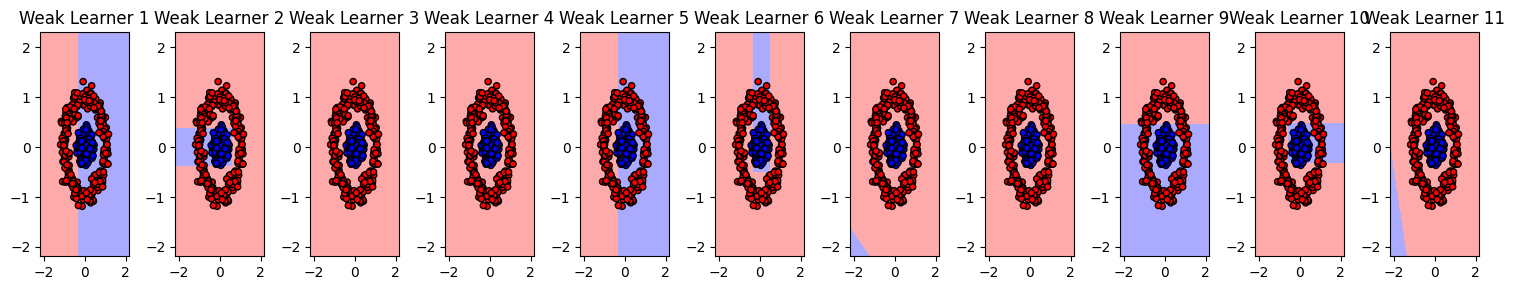

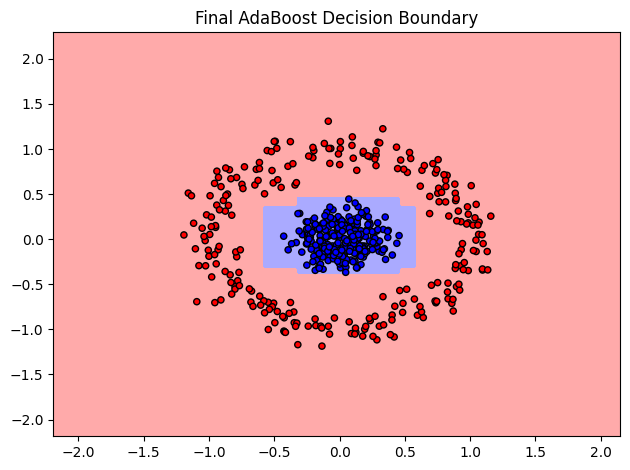

In [13]:
ada = NewAdaboost(weak_learners,best_n_learner,best_eta)
ada.fit(X_train,y_train)
ada.plot_decision_boundaries(X,y)
ada.plot_final_decision_boundary(X,y)

In [14]:
print(classification_report(y_test, ada.predict(X_test)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        64

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [15]:
print('Alpha Values')
print(*[float(i) for i in ada.alphas])
print('')
print('Error Values')
print(*[float(i) for i in ada.errors])

Alpha Values
0.08157495026522778 0.2784419309844741 0.018076991563568134 0.014461593250854552 0.07601105252612646 0.25407642623354937 0.027759598168646177 0.02220767853491694 0.06906422320433118 0.2438632275575365 0.03331186994698053

Error Values
0.30666666666666664 0.05817195718378032 0.4549301860224531 0.46390889504194815 0.3186222704615117 0.0730494058921569 0.4310432514491629 0.4447078590343845 0.33389022076378083 0.08027383324030996 0.41748198958927984
